## Clickbait spoiling notebook

In [1]:
# Data processing
import pandas as pd
import string
import re
import json
import torch
import numpy as np
import math

# OpenAI connection
import os
from dotenv import load_dotenv
from openai import OpenAI
import tiktoken
from typing import List
from datetime import datetime

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer

c:\Users\wojom\anaconda3\envs\eda_clickbait-detection\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
# VARIABLES
load_dotenv()
api_key = os.getenv("OPEN_AI_KEY")
nltk.download('wordnet')
nltk.download('punkt_tab')

N = 400 # Number of samples for charts
RANDOM_STATE = 42 # Random state for reproducibility

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wojom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wojom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
def calculate_cost(prompt: str, data: str, out: str, model: str = "gpt-4o-mini") -> float:
    """
    Calculates the cost of a request to a OPEN AI model based on the 
    , data, and output

    Args:
        prompt (str): prompt sent to the LLM
        data (str): additional data sent to the LLM.
        out (str): response received from the LLM.
        model (str): model identifier used to determine the tokenizer, defaults to "gpt-4o-mini"

    Returns:
        float: total cost of the tokens used in USD
    """
    tokenizer = tiktoken.encoding_for_model(model)  
    request = str(prompt) + str(data)
    response = str(out)

    request_tokens = tokenizer.encode(request)
    response_tokens = tokenizer.encode(response)

    input_tokens = len(request_tokens)
    output_tokens = len(response_tokens)

    # costs per 1 million tokens
    cost_per_1M_input_tokens = 0.15  # $0.15 per 1M input tokens
    cost_per_1M_output_tokens = 0.60  # $0.60 per 1M output tokens

    input_cost = (input_tokens / 10**6) * cost_per_1M_input_tokens
    output_cost = (output_tokens / 10**6) * cost_per_1M_output_tokens
    total_cost = input_cost + output_cost
    total_tokens = input_tokens + output_tokens

    print(f"Input tokens: {input_tokens}")
    print(f"Output tokens: {output_tokens}")
    print(f"Total tokens: {total_tokens}")
    print(f"Cost: ${total_cost:.5f}")
    return total_cost, total_tokens

In [4]:
spoil_df = pd.read_csv("../data/spoiling_data.csv", sep=";")
print(spoil_df.shape)
tags = spoil_df["tags"].unique().tolist()
print(tags)

(3358, 6)
['passage', 'phrase', 'multi']


In [5]:
spoil_df = spoil_df.dropna()
spoil_df.isna().sum()

targetTitle         0
targetParagraphs    0
humanSpoiler        0
spoiler             0
tags                0
spoilerPositions    0
dtype: int64

In [6]:
client = OpenAI(api_key=api_key)

In [7]:
spoil_df["paragraphsLength"] = spoil_df["targetParagraphs"].apply(lambda x: len(x))
mean_length = spoil_df["paragraphsLength"].mean()
median_length = spoil_df["paragraphsLength"].median()

print("Mean length of the paragraph:", mean_length)
print("Median length of the paragraph:", median_length)

Mean length of the paragraph: 2864.8784629133156
Median length of the paragraph: 1974.0


### Direct Prompt

In [8]:
spoil_df[spoil_df["paragraphsLength"] == min(spoil_df["paragraphsLength"])]

,targetTitle,targetParagraphs,humanSpoiler,spoiler,tags,spoilerPositions,paragraphsLength
696,The Grand Tour launch date,November 18 The Grand Tour: Launch Date,November 18,November 18,phrase,"[[[0, 0], [0, 11]]]",39


In [9]:
pd.set_option('display.max_colwidth', None)
examples = {}
tags = spoil_df["tags"].unique()

for tag in tags:
    spoiler = spoil_df.loc[(spoil_df["tags"] == tag) & (spoil_df["paragraphsLength"] < 1000)].iloc[0]
    examples[tag] = {
        "tag": spoiler["tags"],
        "spoiler": spoiler["spoiler"],
        "title": spoiler["targetTitle"],
        "paragraph": spoiler["targetParagraphs"],
        "human_spoiler": spoiler["humanSpoiler"],
        "length": spoiler["paragraphsLength"]
    }


print(examples["multi"]["spoiler"])
pd.set_option('display.max_colwidth', 50)

pravastatin, paroxetine


In [10]:
prompt = f"""\
You are a model designed to generate concise spoilers from articles. Your task is to analyze the main question or topic posed by the article’s title and generate a spoiler based on the content provided in the article's paragraphs. Your response must include a JSON object with keys "humanSpoiler", and "spoiler".\
Use "targetTitle" to determine the central question or topic the spoiler should address. Review "targetParagraphs" to find the most relevant details that directly answer or the topic stated in the title. Consider the provided tag:\
"phrase": Short, direct answer or single phrase.\
"passage": More detailed, informative spoiler.\
"multi": Multiple sentences or complex information for a full response, provide a longer, structured spoiler.\
\
Answer: {{\
    "humanSpoiler": "<A model-generated spoiler>",\
    "spoiler": "<A concise, extracted from the article’s content but remaining logical>"\
}}\
Example 1:\
Input{{\
    "idx": 1,\
    "tag": "phrase",\
    "targetTitle": {examples['phrase']['title']},\
    "targetParagraphs": {examples["phrase"]["paragraph"]}\
}}\
\
Output{{\
    "idx":1,\
    "humanSpoiler": {examples["phrase"]["human_spoiler"]},\
    "spoiler": {examples["phrase"]["spoiler"]}\
}}\
\
Example 2:\
Input{{\
    "idx":2,\
    "tag": "passage",\
    "targetTitle": {examples["passage"]["title"]},\
    "targetParagraphs": {examples["passage"]["paragraph"]}\
}}\
Output{{\
    "idx":2,\
    "humanSpoiler": {examples["passage"]["human_spoiler"]},\
    "spoiler": {examples["passage"]["spoiler"]}\
}}\
\
Example 3:\
Input{{\
    "idx:3"\
    "tag": "multi",\
    "targetTitle": {examples["multi"]["title"]},\
    "targetParagraphs": {examples["multi"]["paragraph"]}\
}}\
Output{{\
    "idx:3"\
    "humanSpoiler": {examples["multi"]["human_spoiler"]},\
    "spoiler": {examples["multi"]["spoiler"]}\
}}\
Pay attention to return valid JSON format!\
"""


In [11]:
cost_one, tokens_one = calculate_cost(prompt=prompt, data="", out="Intellectual stimulation")
print(f"Total cost: ${cost_one * 4000}")

Input tokens: 836
Output tokens: 3
Total tokens: 839
Cost: $0.00013
Total cost: $0.5088


In [ ]:
def sample_test_df(df, types_of_spoilers, num_samples, random_state=RANDOM_STATE):
    samples = []
    for tag in types_of_spoilers:
        sample = df[df['tags'] == tag].sample(num_samples, random_state=random_state)
        samples.append(sample)
    test_df = pd.concat(samples).reset_index(drop=True)
    return test_df

In [13]:
test_df = sample_test_df(spoil_df, types_of_spoilers=['passage', 'phrase', 'multi'], num_samples=10)
test_df.shape

(30, 7)

### Call to the OpenAI. Response saved as file

In [14]:
def create_batch_request_to_open_ai_direct_prompt(
    list_of_prompts: List[str],
    name_of_request_file: str,
    description_of_request: str,   
    temperature: None = 1, #between [0,2]. Default = 1, higher temperature leads to more random, while lower to more deterministic,
    model: str = "gpt-4o-mini"
):

    dictionary = [{
        "custom_id": f"request{i}", 
        "method": "POST", 
        "url": "/v1/chat/completions", 
        "body": {"model": model, 
                 "messages": [
                     {"role": "system", "content": "assistant"},
                     {"role": "user", "content": prompt__}],
                 "max_tokens": 1000,
                 "temperature": temperature}
    } for i, prompt__ in enumerate(list_of_prompts)]
    
    with open(f"../request_files_openai/{name_of_request_file}.jsonl", "w") as outfile:
        for request__ in dictionary:
            json.dump(request__, outfile)
            outfile.write('\n')
    
    
    batch_input_file = client.files.create(
      file=open(fr"../request_files_openai/{name_of_request_file}.jsonl", "rb"),
      purpose="batch"
    )
    
    return client.batches.create(
        input_file_id=batch_input_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={
          "description": description_of_request
        }
    )

In [15]:
def save_direct_prompt_to_file_and_get_predictions(
    result_file_id: str,
    result_file_name: str,
    save_to_file: bool = True
):
    if save_to_file:
        result = client.files.content(result_file_id).content
        result_file_name = f"../request_files_openai/{result_file_name}.jsonl"
        
        with open(result_file_name, 'wb') as file:
            file.write(result)

    pred = []
    with open(result_file_name, 'r') as file:
        i = 0
        for line in file:
            prediction_str = json.loads(line)['response']['body']['choices'][0]['message']['content']
            try:
                pred.append(str(prediction_str))
            except Exception as e:
                print("there was problem with this request. Output:")
                print(prediction_str)
                print()
                pred.append(0)
                i+=1
    print(f"number of errors = {i}")
    return pred

In [16]:
def create_prompt(df):
    prompt_res = [
        str(prompt + f'Article to spoil: "idx":{idx}, "tag":{entry["tags"]}, "targetTitle":{entry["targetTitle"]}, "targetParagraphs":{entry["targetParagraphs"]}')
        for idx, entry in df.iterrows()
    ]
    return prompt_res

In [17]:
def divide_for_batches(data_prompt, num_batches):
    batches = []
    size = len(data_prompt) // num_batches
    for i in range(num_batches):
        if i == num_batches-1:
            batches.append(data_prompt[size*i:])
            break
        batches.append(data_prompt[size*i:size*(i+1)])
    return batches

Call to OpenAI with the whole dataset

In [18]:
data_prompt = create_prompt(spoil_df)
print("Length of the prompt:", len(data_prompt))

Length of the prompt: 3357


In [19]:
toatal_cost, total_tokens = calculate_cost(prompt=data_prompt, data="", out=data_prompt[0])
tokens_limit = 2000000
num_batches = math.ceil(total_tokens/tokens_limit)
print("Number of batches to form from data:", num_batches)

Input tokens: 5002194
Output tokens: 1252
Total tokens: 5003446
Cost: $0.75108
Number of batches to form from data: 3


In [20]:
prompt_batches = divide_for_batches(data_prompt, num_batches)
print("Num of batches:", len(prompt_batches))

Num of batches: 3


In [73]:
data_batch = create_batch_request_to_open_ai_direct_prompt(
        list_of_prompts = prompt_batches[2],
        name_of_request_file = "request_spoiling",
        description_of_request = f"request_spoiling_{str(datetime.now().date())}_batch{2})",
)

In [74]:
print(data_batch.id)

batch_6740404988d88190b9865501d4a2c3a6


In [ ]:
in_progress_data_batch = client.batches.retrieve(data_batch.id)
print("Batch in progress output file id:", in_progress_data_batch.output_file_id)
print("Batch details:", in_progress_data_batch)

Batch in progress output file id: None
Batch details: Batch(id='batch_673edf4d06d48190b00e115bc855446d', completion_window='24h', created_at=1732173645, endpoint='/v1/chat/completions', input_file_id='file-TJfzHU4sPdpMkNeurmKelTw4', object='batch', status='in_progress', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1732260045, failed_at=None, finalizing_at=None, in_progress_at=1732173646, metadata={'description': 'request_spoiling_2024-11-21_batch2)'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=1120))


In [28]:
file_response = client.files.content(in_progress_data_batch.output_file_id).content

NameError: name 'in_progress_data_batch' is not defined

In [193]:
pred = save_direct_prompt_to_file_and_get_predictions(
    result_file_id = in_progress_data_batch.output_file_id,
    result_file_name = f"response_spoiling_{str(datetime.now().date())}_batch_{2}"
)

number of errors = 0


### Spoiling analysis from files

In [21]:
file_names = [
    "response_spoiling_2024-11-20_batch_0", 
    "response_spoiling_2024-11-21_batch_1", 
    "response_spoiling_2024-11-21_batch_2"
    ]

In [22]:
pred = []
for file_name in file_names:
    result_file_name = "../request_files_openai/" + file_name + ".jsonl"
    pred_file = save_direct_prompt_to_file_and_get_predictions(
        result_file_id = None,
        result_file_name = result_file_name,
        save_to_file = False
    )
    pred.extend(pred_file)
print(len(pred))

number of errors = 0
number of errors = 0
number of errors = 0
3358


In [23]:
def extract_data_regex(pred):
    pattern = r'[{}\n":,]'
    human_spoiler_pattern = r'"humanSpoiler"\s*:\s*"([^"]+)"'
    spoiler_pattern = r'"spoiler"\s*:\s*"([^"]+)"'
    data = []

    for text in pred:
        human_spoiler_value = spoiler_value = None
        human_spoiler_match = re.search(human_spoiler_pattern, text)
        spoiler_match = re.search(spoiler_pattern, text)
        if human_spoiler_match:
            human_spoiler_value = human_spoiler_match.group(1)
        else:
            match = re.search(r'humanSpoiler', text)
            if match:
                start_index = match.start()
                human_spoiler_value = text[start_index+12:] 
        
        if spoiler_match:
            spoiler_value = spoiler_match.group(1)
        else:
            match = re.search(r'spoiler', text)
            if match:
                start_index = match.start()
                spoiler_value = text[start_index+7:] 
        
        
        data.append({
            "humanSpoiler": human_spoiler_value,
            "spoiler": spoiler_value
        })

    df = pd.DataFrame(data)
    return df


In [24]:
def load_json_result(result, tags):
    json_spoiler = json.loads(result)
    data_point = {
        "humanSpoiler": json_spoiler[tags[0]],
        "spoiler": json_spoiler[tags[1]]
    }
    return data_point
    
def extract_data(pred):
    wrong_rows = []
    data = []
    for i in range(len(pred)):
        match = re.search(r'\{.*?\}', pred[i], re.DOTALL)
        if match:
            result = match.group(0)
            try:
                data.append([load_json_result(result, tags = ["humanSpoiler", "spoiler"]), i])
            except json.JSONDecodeError as e:
                try:
                    result = result.replace('"humanSpoiler": ', '"humanSpoiler": "')
                    result = result.replace('"spoiler": ', '"spoiler": "')
                    result = result.replace('\n}', '"\n}')
                    data.append([load_json_result(result, tags = ["humanSpoiler", "spoiler"]), i])
                except json.JSONDecodeError as e:
                    wrong_rows.append(spoiler)
                    print(f"JSON decode error: {e}")      
        else:
            print("No match found.")
    idx = [el[1] for el in data]
    data = [el[0] for el in data]
    data = pd.DataFrame(data)
    data["idx"] = idx
    return data, wrong_rows

In [25]:
extracted_df, wrong_rows = extract_data(pred)
na_rows = extracted_df[extracted_df.isna().any(axis=1)]
print("Extracted data size: ", extracted_df.shape)
print("Non-extracted data size: ", len(wrong_rows))
print("Rows with NaN values in extracted data: ", na_rows.shape)

JSON decode error: Expecting ',' delimiter: line 2 column 23 (char 24)
JSON decode error: Expecting ',' delimiter: line 3 column 301 (char 458)
JSON decode error: Invalid control character at: line 2 column 65 (char 66)
JSON decode error: Invalid control character at: line 2 column 97 (char 98)
JSON decode error: Invalid control character at: line 2 column 71 (char 72)
JSON decode error: Expecting ',' delimiter: line 3 column 385 (char 522)
JSON decode error: Invalid control character at: line 2 column 43 (char 44)
JSON decode error: Expecting ',' delimiter: line 3 column 210 (char 381)
JSON decode error: Invalid control character at: line 2 column 125 (char 126)
JSON decode error: Invalid control character at: line 2 column 69 (char 70)
JSON decode error: Invalid control character at: line 2 column 122 (char 123)
JSON decode error: Invalid control character at: line 2 column 75 (char 76)
JSON decode error: Invalid control character at: line 2 column 86 (char 87)
JSON decode error: Inv

In [26]:
extracted_df.head()

,humanSpoiler,spoiler,idx
0,Brady suggested throwing instead of dinner.,Tom Brady proposed to Wes Welker that instead ...,0
1,Ozone layer recovery by 2070,"By 2070, the hole in the ozone layer is expect...",1
2,Intellectual stimulation,intellectually stimulated is the most importan...,2
3,No anti-theft measures.,Apple does not have any anti-theft measures fo...,3
4,Superstition and good luck in football matches.,Gabor Kiraly wears grey tracksuit bottoms due ...,4


### Calculating Metrics
- **BLEU**
- **BERTScore (BSc)**
- **METEOR (MET)**
- **Cosine Similarity**

The dataset with spoilers from OpenAI and all calculated metrics is saved as: `../data/spoiling_metrics_df.csv`. Generating the dataset again is computationally expensive!


In [ ]:
def plotHistograms(df, columns, xlabels, titles, kde=False, log=False, font_size=12):
    number = len(columns)
    fig, axs = plt.subplots(1, number, figsize=(12, 5))

    for i in range(number):
        sns.histplot(df[columns[i]], bins=10, kde=kde, ax=axs[i], edgecolor="black")
        axs[i].set_xlabel(xlabels[i], fontsize=font_size)
        axs[i].set_ylabel('Counts' + (' (log scale)' if log else ''), fontsize=font_size)
        axs[i].set_title(titles[i], fontsize=font_size + 2)
        axs[i].tick_params(axis='both', which='major', labelsize=font_size - 2)  # Adjust tick font size
        if log:
            axs[i].set_yscale('log')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_scatterplot(df, columns, legend_labels, mean_labels, xlabel, ylabel, title, random_state=RANDOM_STATE, n=N, fontsize=14):
    sampled_0 = df[columns[0]].sample(n=n, random_state=random_state)
    sampled_1 = df[columns[1]].sample(n=n, random_state=random_state)

    human_spoiler_mean = df[columns[0]].mean()
    spoiler_mean = df[columns[1]].mean()

    plt.figure(figsize=(10, 6))

    plt.scatter(
        range(len(sampled_0)), 
        sampled_0, 
        alpha=0.7, 
        color='blue', 
        label=legend_labels[0]
    )

    plt.scatter(
        range(len(sampled_1)), 
        sampled_1, 
        alpha=0.7, 
        color='orange', 
        label=legend_labels[1]
    )

    plt.axhline(y=human_spoiler_mean, color='blue', linestyle='--', label=mean_labels[0])
    plt.axhline(y=spoiler_mean, color='orange', linestyle='--', label=mean_labels[1])

    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.title(title, fontsize=fontsize+2)
    plt.legend(loc='upper right', prop={'size': fontsize-2})

    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    plt.tight_layout()
    plt.show()


In [77]:
# metrics df laded from csv:
metrics_df = pd.read_csv("../data/spoiling_metrics_df.csv", sep=";")

In [27]:
metrics_df = extracted_df.merge(spoil_df, left_on='idx', right_index=True)
metrics_df.rename(columns={
    'humanSpoiler_x': 'humanSpoiler_ext', 
    'spoiler_x': 'spoiler_ext',
    'humanSpoiler_y': 'humanSpoiler_org', 
    'spoiler_y': 'spoiler_org',
    }, inplace=True)
metrics_df.drop(columns=["idx"], inplace=True)
metrics_df.head()

,humanSpoiler_ext,spoiler_ext,targetTitle,targetParagraphs,humanSpoiler_org,spoiler_org,tags,spoilerPositions,paragraphsLength
0,Brady suggested throwing instead of dinner.,Tom Brady proposed to Wes Welker that instead ...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It will be just like old times this weekend fo...,They Threw A Football,how about that morning we go throw?,passage,"[[[3, 151], [3, 186]]]",1670
1,Ozone layer recovery by 2070,"By 2070, the hole in the ozone layer is expect...",Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,2070,2070,phrase,"[[[0, 0], [0, 4]]]",2092
2,Intellectual stimulation,intellectually stimulated is the most importan...,Intellectual Stimulation Trumps Money For Empl...,"Despite common belief, money is not the key to...",Intellectual stimulation,intellectual stimulation,phrase,"[[[1, 186], [1, 210]]]",1774
3,No anti-theft measures.,Apple does not have any anti-theft measures fo...,Here Is what happens if your Apple AirPods get...,One of the biggest surprise announcements at A...,No,"Apple says that if AirPods are lost or stolen,...",passage,"[[[4, 0], [4, 110]]]",1098
4,Superstition and good luck in football matches.,Gabor Kiraly wears grey tracksuit bottoms due ...,The Reason Why Gabor Kiraly Wears THOSE Tracki...,"June 14th 2016 3.3K Shares, They may look like...",Its a lucky charm to him,"The more good games I had in them, the more I ...",passage,"[[[5, 0], [5, 64]]]",1087


#### Cosine Similarity for spoiler, humanSpoiler

In [28]:
vectorizer = TfidfVectorizer()
def calculate_cosine_similarity_row(row, columns):
    tfidf_matrix = vectorizer.fit_transform([row[columns[0]], row[columns[1]]])
    cosine_sim = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    return cosine_sim

In [33]:
metrics_df['humanSpoiler_cos_sim'] = metrics_df.apply(calculate_cosine_similarity_row, axis=1, columns=['humanSpoiler_ext', 'humanSpoiler_org'])
metrics_df['spoiler_cos_sim'] = metrics_df.apply(calculate_cosine_similarity_row, axis=1, columns=['spoiler_ext', 'spoiler_org'])

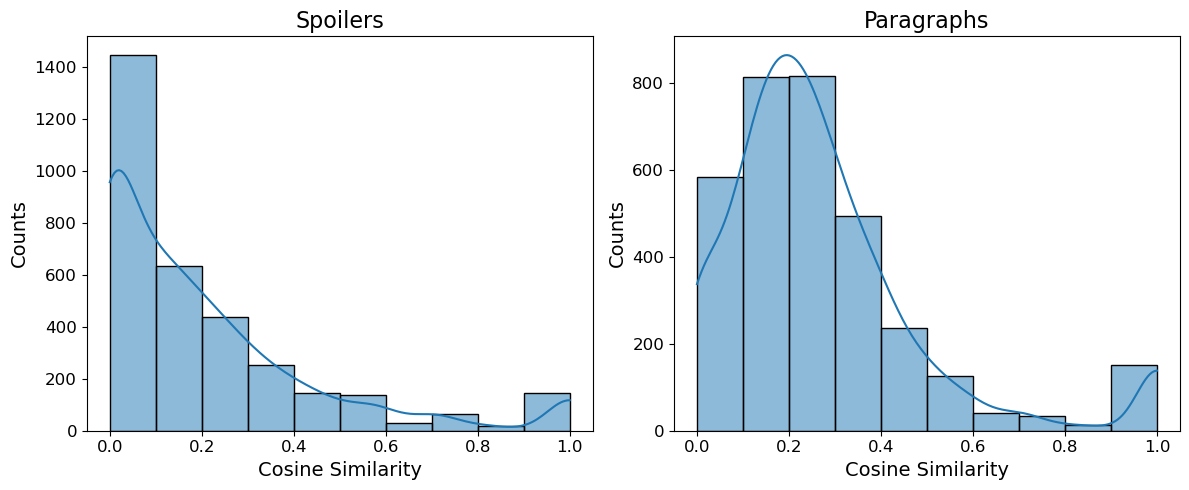

In [117]:
xlabels = ['Cosine Similarity', 'Cosine Similarity']
titles = ['Spoilers', 'Paragraphs']
plotHistograms(metrics_df, columns=["humanSpoiler_cos_sim", "spoiler_cos_sim"], xlabels=xlabels, titles=titles, kde=True, font_size=14)

In [36]:
print("Mean of humanSpoiler_cos_sim: ", metrics_df["humanSpoiler_cos_sim"].mean())
print("Mean of spoiler_cos_sim: ", metrics_df["spoiler_cos_sim"].mean())

Mean of humanSpoiler_cos_sim:  0.20664062769502015
Mean of spoiler_cos_sim:  0.2735297847111959


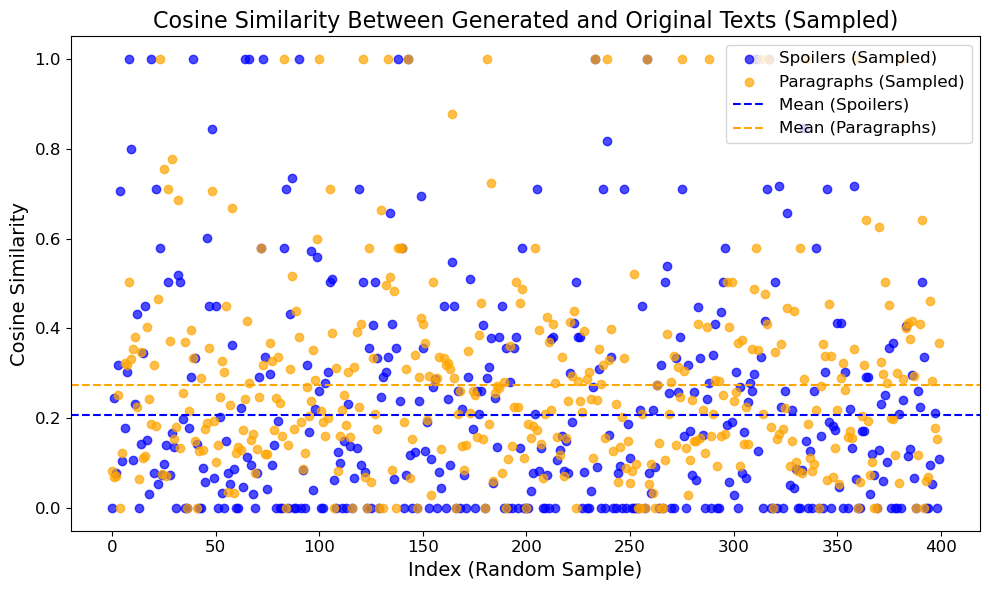

In [120]:
plot_scatterplot(
    df=metrics_df, 
    columns=["humanSpoiler_cos_sim", "spoiler_cos_sim"], 
    legend_labels=['Spoilers (Sampled)', 'Paragraphs (Sampled)'], 
    mean_labels=['Mean (Spoilers)', 'Mean (Paragraphs)'], 
    xlabel='Index (Random Sample)', 
    ylabel='Cosine Similarity', 
    title='Cosine Similarity Between Generated and Original Texts (Sampled)', 
    random_state=RANDOM_STATE, 
    n=N
    )

In general, the model 'gpt-4o-mini' identifies paragraphs for extracting spoilers with higher mean value than the similarity of generated spoilers.

#### METEOR (MET) for spoiler, humanSpoiler
https://www.nltk.org/api/nltk.translate.meteor_score.html

In [55]:
def calculate_met_nltk(row, columns):
    tokenized_candidate = word_tokenize(row[columns[0]])
    tokenized_reference = word_tokenize(row[columns[1]])

    return meteor_score([tokenized_reference], tokenized_candidate)

In [56]:
metrics_df["humanSpoiler_met"] = metrics_df.apply(calculate_met_nltk, axis=1, columns=['humanSpoiler_ext', 'humanSpoiler_org'])
metrics_df['spoiler_met'] = metrics_df.apply(calculate_met_nltk, axis=1, columns=['spoiler_ext', 'spoiler_org'])

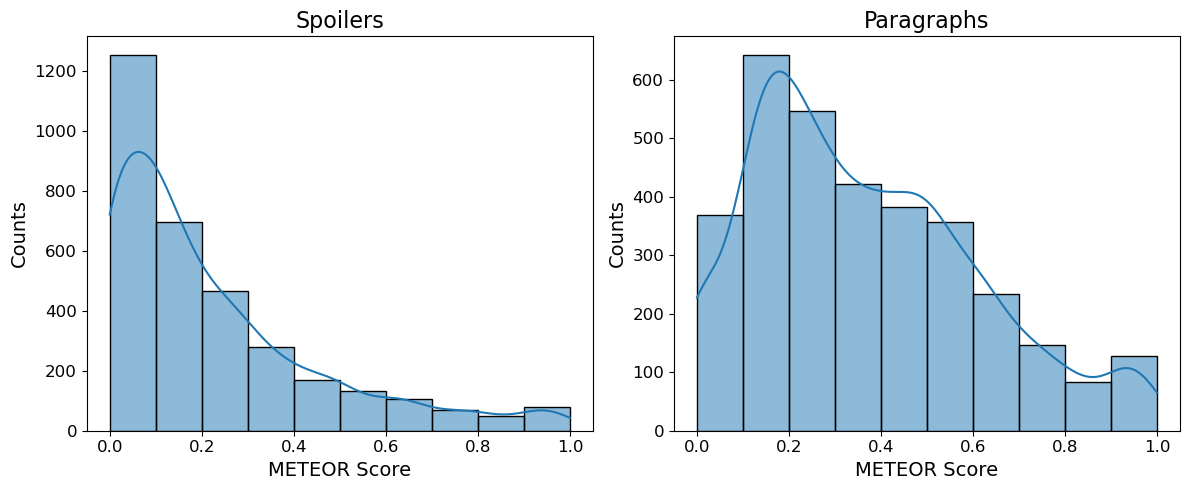

In [116]:
xlabels = ['METEOR Score','METEOR Score']
titles = ['Spoilers','Paragraphs']
plotHistograms(metrics_df, columns=["humanSpoiler_met", "spoiler_met"], xlabels=xlabels, titles=titles, kde=True, font_size=14)

In [58]:
print("Mean of humanSpoiler_met: ", metrics_df["humanSpoiler_met"].mean())
print("Mean of spoiler_met: ", metrics_df["spoiler_met"].mean())

Mean of humanSpoiler_met:  0.22648357684961115
Mean of spoiler_met:  0.3650329613129407


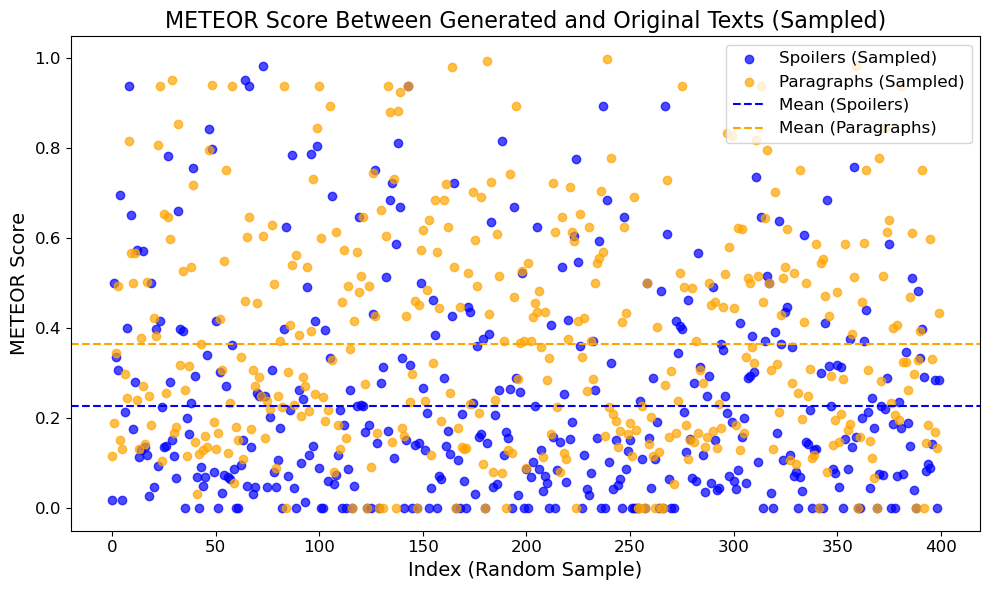

In [119]:
plot_scatterplot(
    df=metrics_df, 
    columns=["humanSpoiler_met", "spoiler_met"], 
    legend_labels=['Spoilers (Sampled)', 'Paragraphs (Sampled)'], 
    mean_labels=['Mean (Spoilers)', 'Mean (Paragraphs)'], 
    xlabel='Index (Random Sample)', 
    ylabel='METEOR Score', 
    title='METEOR Score Between Generated and Original Texts (Sampled)', 
    random_state=RANDOM_STATE, 
    n=N)

#### BLEU for spoiler, humanSpoiler
https://stackoverflow.com/questions/32395880/calculate-bleu-score-in-python

In [62]:
def calculate_bleu_nltk(row, columns):
    tokenized_candidate = word_tokenize(row[columns[0]])
    tokenized_reference = word_tokenize(row[columns[1]])
    smoothing_function = SmoothingFunction().method1
    
    return round(sentence_bleu(
        [tokenized_reference], 
        tokenized_candidate, 
        smoothing_function=smoothing_function, 
        weights=[0.40, 0.30, 0.20, 0.10]
        ), 3)

In [63]:
metrics_df["humanSpoiler_bleu"] = metrics_df.apply(calculate_bleu_nltk, axis=1, columns=['humanSpoiler_ext', 'humanSpoiler_org'])
metrics_df["spoiler_bleu"] = metrics_df.apply(calculate_bleu_nltk, axis=1, columns=['spoiler_ext', 'spoiler_org'])

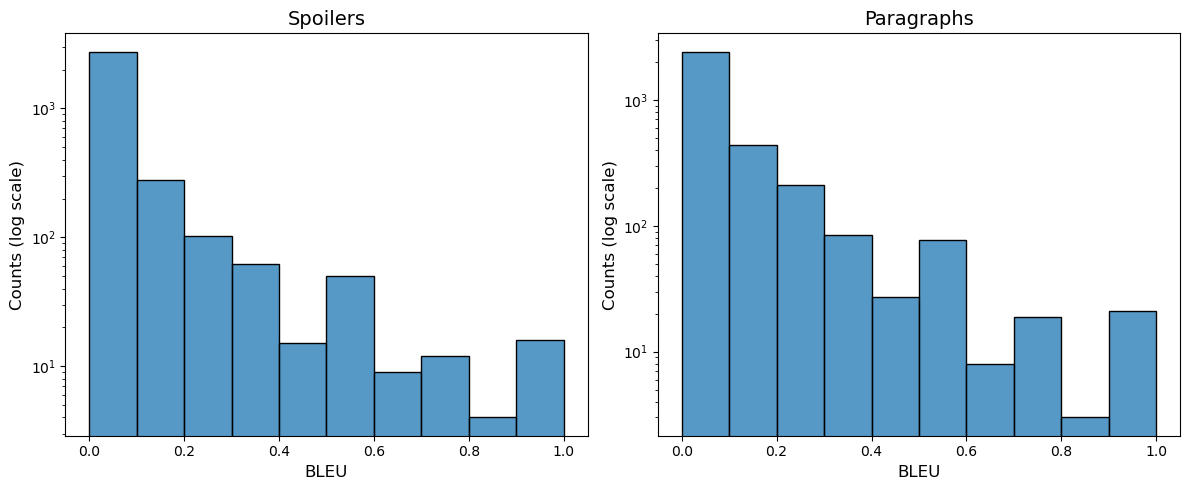

In [101]:
xlabels = ['BLEU','BLEU']
titles = ['Spoilers','Paragraphs']
plotHistograms(metrics_df, columns=["humanSpoiler_bleu", "spoiler_bleu"], xlabels=xlabels, titles=titles, kde=False, log=True, font_size=12)

In [64]:
print("Mean of humanSpoiler_bleu: ", metrics_df["humanSpoiler_bleu"].mean())
print("Mean of spoiler_bleu: ", metrics_df["spoiler_bleu"].mean())

Mean of humanSpoiler_bleu:  0.0678912058023572
Mean of spoiler_bleu:  0.09364158355998792


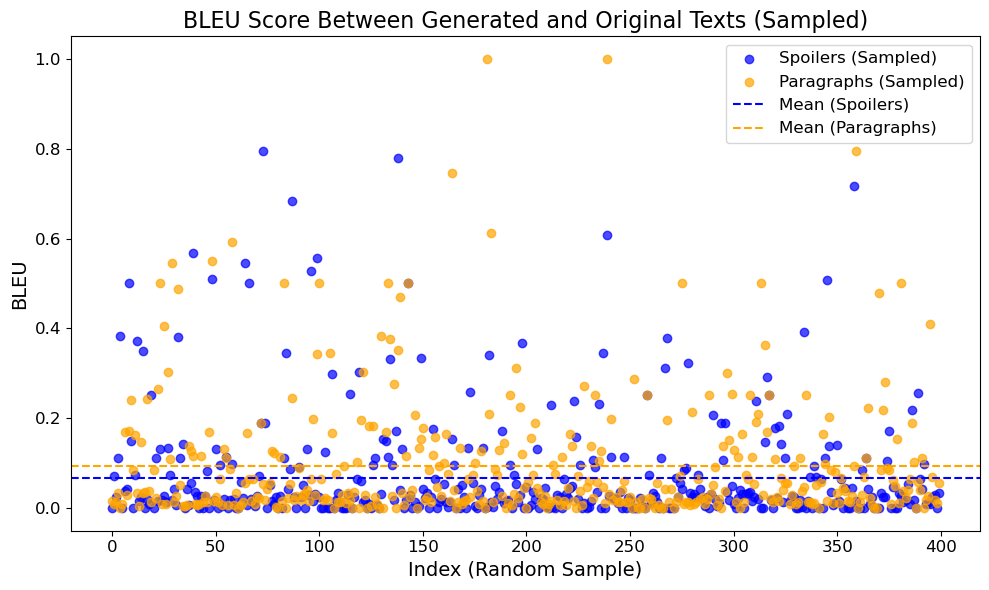

In [112]:
plot_scatterplot(
    df=metrics_df, 
    columns=["humanSpoiler_bleu", "spoiler_bleu"], 
    legend_labels=['Spoilers (Sampled)', 'Paragraphs (Sampled)'], 
    mean_labels=['Mean (Spoilers)', 'Mean (Paragraphs)'], 
    xlabel='Index (Random Sample)', 
    ylabel='BLEU', 
    title='BLEU Score Between Generated and Original Texts (Sampled)', 
    random_state=RANDOM_STATE, 
    n=N)

#### BERTScore (BSc) for spoiler, humanSpoiler
https://haticeozbolat17.medium.com/text-summarization-how-to-calculate-bertscore-771a51022964
https://rumn.medium.com/bert-score-explained-8f384d37bb06

In [67]:
scorer = BERTScorer(model_type='bert-base-uncased', lang="en")

def calculate_bertscore(row, columns):
    P, R, F1 = scorer.score([row[columns[0]]], [row[columns[1]]])
    return P.mean().item(), R.mean().item(), F1.mean().item()

In [68]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def calculate_bert_similarity(row, columns):
    embeddings = []
    for column in columns:
        text = row[column]
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs)
        # The mean of the last hidden state. Squeeze to remove batch dimension.
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
        embeddings.append(embedding)
    
    similarity = np.dot(embeddings[0], embeddings[1]) / (np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1]))
    return similarity

metrics_df["bertScore"] = metrics_df.apply(calculate_bert_similarity, columns=["humanSpoiler_org", "humanSpoiler_ext"], axis=1)


In [ ]:
# this cell executes for longer time ~ 9 minutes
metrics_df[["hs_bert_precision", "hs_bert_recall", "hs_bert_f1"]] = metrics_df[["humanSpoiler_org", "humanSpoiler_ext"]].apply(calculate_bertscore, columns=["humanSpoiler_org", "humanSpoiler_ext"], axis=1, result_type="expand")
metrics_df[["s_bert_precision", "s_bert_recall", "s_bert_f1"]] = metrics_df[["spoiler_org", "spoiler_ext"]].apply(calculate_bertscore, columns=["spoiler_org", "spoiler_ext"], axis=1, result_type="expand")

In [71]:
# this chart might be better
metrics_df["index"] = metrics_df.index
metrics_long = metrics_df.melt(
    id_vars="index", 
    value_vars=["hs_bert_precision", "s_bert_precision"], 
    var_name="Line Type", 
    value_name="Precision"
)
fig = px.line(
    metrics_long, 
    x="index", 
    y="Precision", 
    color="Line Type", 
    title="BERT Precision Comparison", 
    labels={"index": "Index", "Precision": "Precision"}
)

fig.update_layout(
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    template="plotly_white"
)

fig.show()

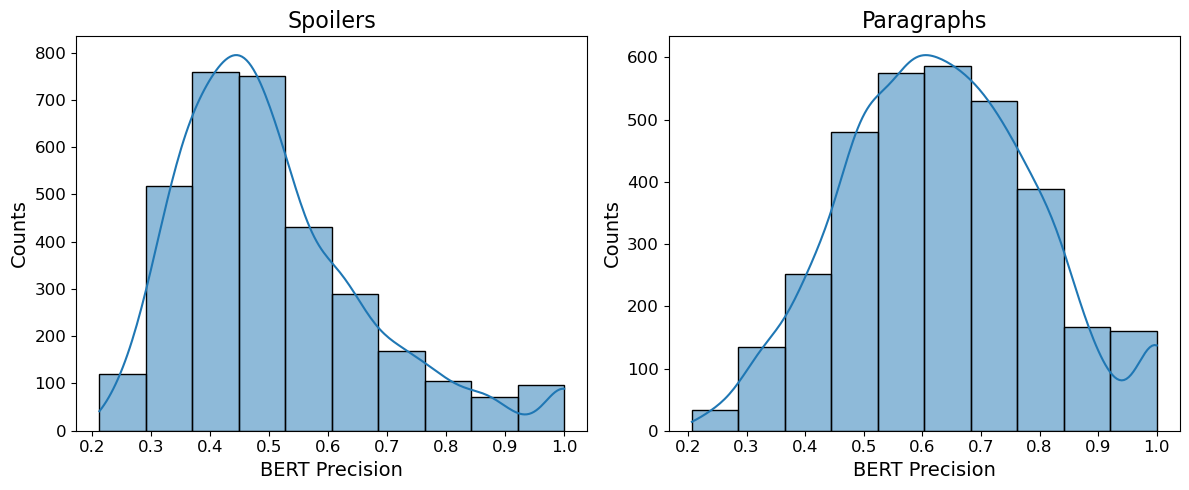

In [118]:
xlabels = ['BERT Precision','BERT Precision']
titles = ['Spoilers','Paragraphs']
plotHistograms(metrics_df, columns=["hs_bert_precision", "s_bert_precision"], xlabels=xlabels, titles=titles, kde=True, font_size=14)

In [ ]:
# this cell executes long time ~ 14 minutes
metrics_df["humanSpoiler_bertScore"] = metrics_df.apply(calculate_bert_similarity, columns=["humanSpoiler_org", "humanSpoiler_ext"], axis=1)
metrics_df["spoiler_bertScore"] = metrics_df.apply(calculate_bert_similarity, columns=["spoiler_org", "spoiler_ext"], axis=1)

In [80]:
print("Mean of humanSpoiler_bertScore: ", metrics_df["humanSpoiler_bertScore"].mean())
print("Mean of spoiler_bertScore: ", metrics_df["spoiler_bertScore"].mean())

Mean of humanSpoiler_bertScore:  0.6440670979329103
Mean of spoiler_bertScore:  0.6738798272529464


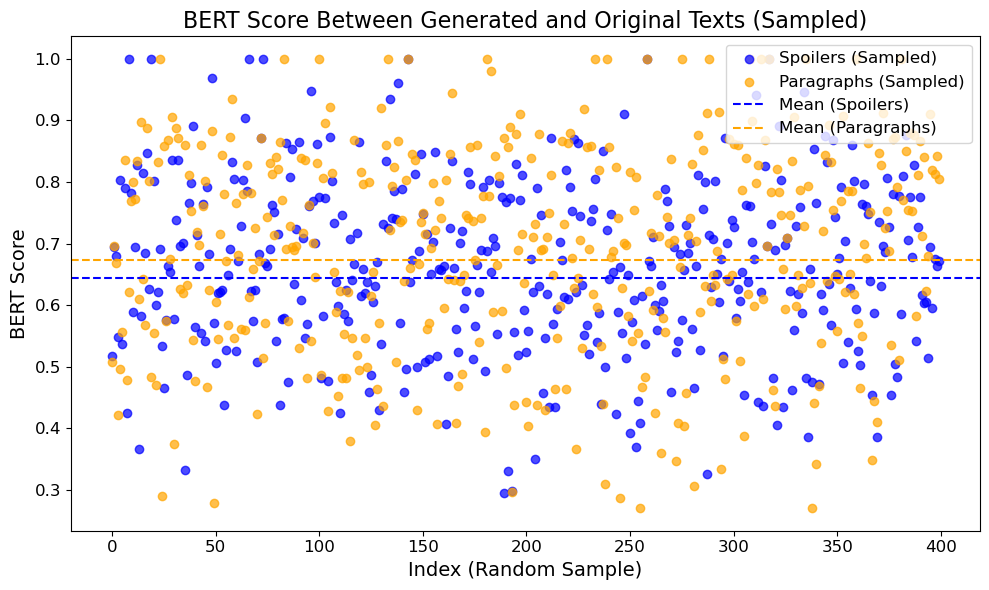

In [113]:
plot_scatterplot(
    df=metrics_df, 
    columns=["humanSpoiler_bertScore", "spoiler_bertScore"], 
    legend_labels=['Spoilers (Sampled)', 'Paragraphs (Sampled)'], 
    mean_labels=['Mean (Spoilers)', 'Mean (Paragraphs)'], 
    xlabel='Index (Random Sample)', 
    ylabel='BERT Score', 
    title='BERT Score Between Generated and Original Texts (Sampled)', 
    random_state=RANDOM_STATE, 
    n=N)

### Saving dataset with spoilers and calculated metrics on them

In [75]:
metrics_df.to_csv("../data/spoiling_metrics_df.csv", index=False, sep=";", header=True)